## Notebook set up

**Your task**: Apply at least two different feature engineering techniques to the `housing_df` dataframe to improve the dataset. At the end of the notebook, your engineered dataset and the original dataset will be used to train a linear regression model to predict `MedHouseVal`. Your goal is to achieve better model performance via feature engineering.

**Note**: If you have read ahead or you are familiar with the basics of training ML models, no there is no train-test split and yes, this means data leakage/genralizability is a concern. We will cover those topics in the next unit. For now, the goal is to keep things simple while still giving you an idea of how your feature engineering effects model performance.

Before applying transformations, explore the dataset to understand what techniques would be most beneficial.

### Import libraries

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Set random seed for reproducibility
np.random.seed(315)

### Load dataset

In [2]:
# Load California housing dataset
original_housing_df = pd.read_csv('https://gperdrizet.github.io/FSA_devops/assets/data/unit2/california_housing.csv')
housing_df = original_housing_df.copy()

## Task 1: Explore the dataset

Before deciding what feature engineering techniques to apply, explore the dataset to understand its characteristics.

**Things to investigate**:
- Display basic information about the dataset (`.info()`, `.describe()`)
- Check for missing values
- Examine feature distributions (histograms, box plots)
- Look at feature scales and ranges

Use this exploration to inform your feature engineering decisions in the following tasks.

Shape: (20640, 9)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


None


Summary statistics:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010



Missing values per column:


MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

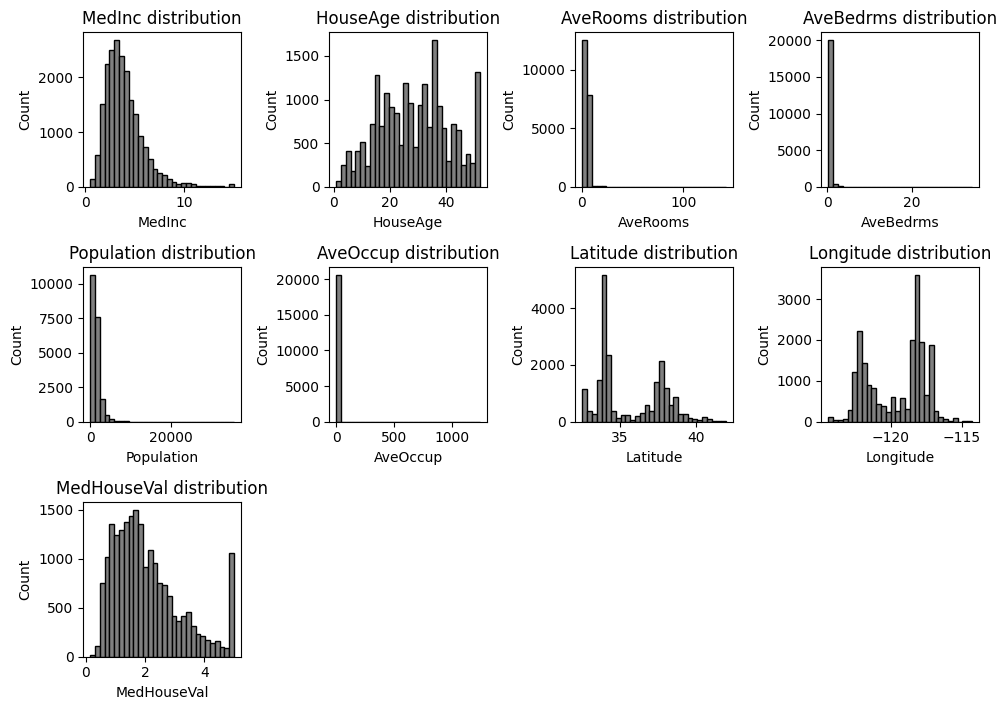

In [3]:
# Explore the dataset structure
print('Shape:', housing_df.shape)
print('\nInfo:')
display(housing_df.info())
print('\nSummary statistics:')
display(housing_df.describe())

# Check for missing values
print('\nMissing values per column:')
display(housing_df.isna().sum())

# Visualize feature distributions
numeric_cols = housing_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
n_cols = 4
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2.5, n_rows*2.4))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    ax.set_title(f'{col} distribution')
    ax.hist(housing_df[col], bins=30, color='grey', edgecolor='black')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

## Task 2: Apply your first feature engineering technique

Based on your exploration, apply your first feature engineering technique.

**Example approaches**:
- Transform skewed features using log, sqrt, power, or quantile transformations
- Create bins/categories from continuous variables
- Create interaction features (e.g., rooms per household = total rooms / households)

In [4]:
# First feature engineering technique: create interaction / ratio features

# Rooms per household and bedrooms per room can better capture density
housing_df['RoomsPerHousehold'] = housing_df['AveRooms'] / housing_df['HouseAge'].replace(0, np.nan)
housing_df['BedroomsPerRoom'] = housing_df['AveBedrms'] / housing_df['AveRooms'].replace(0, np.nan)

# Population per household as another density-related feature
housing_df['PopulationPerHousehold'] = housing_df['Population'] / housing_df['AveOccup'].replace(0, np.nan)

# Replace any infinities that may have arisen and fill remaining NaNs with column medians
housing_df.replace([np.inf, -np.inf], np.nan, inplace=True)
housing_df = housing_df.fillna(housing_df.median(numeric_only=True))

housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,RoomsPerHousehold,BedroomsPerRoom,PopulationPerHousehold
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,0.170345,0.146591,126.0
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,0.297054,0.155797,1138.0
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,0.159387,0.129516,177.0
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,0.111872,0.184458,219.0
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,0.120805,0.172096,259.0


## Task 3: Apply your second feature engineering technique

**Example approaches**:
- Scale features to similar ranges
- Encode any categorical variables you created
- Create aggregate statistics by groups

In [5]:
# Second feature engineering technique: scale numerical features

from sklearn.preprocessing import StandardScaler

# Identify numeric feature columns (excluding the target)
feature_cols = housing_df.columns.drop('MedHouseVal')
numeric_cols = housing_df[feature_cols].select_dtypes(include=['int64', 'float64']).columns.tolist()

scaler = StandardScaler()
scaled_values = scaler.fit_transform(housing_df[numeric_cols])

scaled_df = pd.DataFrame(scaled_values, columns=[f'{col}_scaled' for col in numeric_cols])

# Concatenate scaled columns with original dataframe (keep original features too)
housing_df = pd.concat([housing_df.reset_index(drop=True), scaled_df.reset_index(drop=True)], axis=1)

housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,RoomsPerHousehold,...,HouseAge_scaled,AveRooms_scaled,AveBedrms_scaled,Population_scaled,AveOccup_scaled,Latitude_scaled,Longitude_scaled,RoomsPerHousehold_scaled,BedroomsPerRoom_scaled,PopulationPerHousehold_scaled
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,0.170345,...,0.982143,0.628559,-0.153758,-0.974429,-0.049597,1.052548,-1.327835,-0.285434,-1.145833,-0.977033
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,0.297054,...,-0.607019,0.327041,-0.263336,0.861439,-0.092512,1.043185,-1.322844,0.039531,-0.987175,1.669961
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,0.159387,...,1.856182,1.155620,-0.049016,-0.820777,-0.025843,1.038503,-1.332827,-0.313536,-1.440115,-0.843637
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,0.111872,...,1.856182,0.156966,-0.049833,-0.766028,-0.050329,1.038503,-1.337818,-0.435395,-0.493194,-0.733781
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,0.120805,...,1.856182,0.344711,-0.032906,-0.759847,-0.085616,1.038503,-1.337818,-0.412486,-0.706259,-0.629157


## (Optional) Additional feature engineering

Add more techniques if you'd like to experiment further.

In [6]:
# YOUR CODE HERE (optional)


## Model evaluation

Now we'll compare model performance on the original dataset versus your engineered dataset.

### Evaluate datasets

In [7]:
# Create output directory if it doesn't exist
output_directory = 'data/outputs'
Path(output_directory).mkdir(parents=True, exist_ok=True)

# Save a copy of the engineered dataframe
housing_df.to_csv('data/outputs/housing_df.csv', index=False)

In [8]:
# Create linear regression model
model = LinearRegression()

# Evaluate on original dataset
scores_original = cross_val_score(
    model,
    original_housing_df.drop('MedHouseVal', axis=1),
    original_housing_df['MedHouseVal'],
    cv=10,
    scoring='r2'
)

# Evaluate on engineered dataset
scores_engineered = cross_val_score(
    model,
    housing_df.drop('MedHouseVal', axis=1),
    housing_df['MedHouseVal'],
    cv=10,
    scoring='r2'
)

engineered_mean = scores_engineered.mean()
original_mean = scores_original.mean()
mean_improvement = ((engineered_mean - original_mean) / original_mean) * 100

print(f'\nMean improvement: {mean_improvement:.2f}%')


Mean improvement: 9.26%


### Visualize model performance comparison

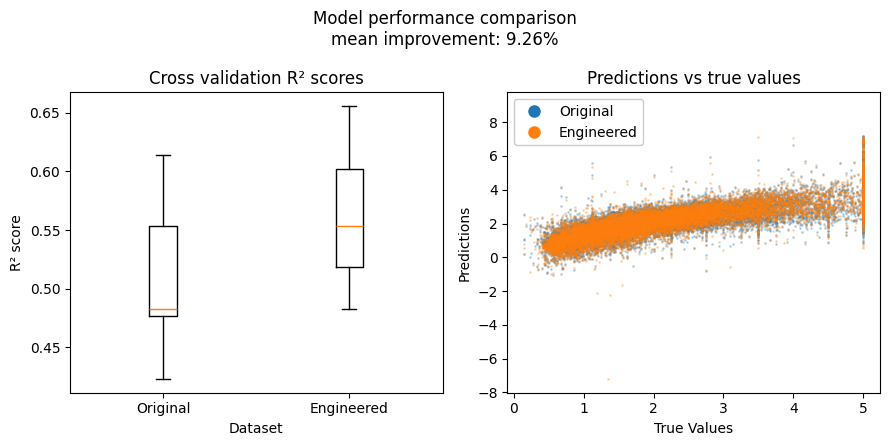

In [9]:
original_model = LinearRegression()
original_model.fit(original_housing_df.drop('MedHouseVal', axis=1), original_housing_df['MedHouseVal'])
original_predictions = original_model.predict(original_housing_df.drop('MedHouseVal', axis=1))

model = LinearRegression()
model.fit(housing_df.drop('MedHouseVal', axis=1), housing_df['MedHouseVal'])
predictions = model.predict(housing_df.drop('MedHouseVal', axis=1))

# Create boxplot comparing performance
data_to_plot = [scores_original, scores_engineered]
labels = ['Original', 'Engineered']

fig, axs = plt.subplots(1, 2, figsize=(9,4.5))

fig.suptitle(f'Model performance comparison\nmean improvement: {mean_improvement:.2f}%')

axs[0].set_title('Cross validation R² scores')
axs[0].boxplot(data_to_plot, tick_labels=labels)
axs[0].set_xlabel('Dataset')
axs[0].set_ylabel('R² score')

axs[1].set_title('Predictions vs true values')
axs[1].plot(
    original_housing_df['MedHouseVal'], original_predictions,
    'o', markersize=1, label='Original', alpha=0.25
)

axs[1].plot(
    housing_df['MedHouseVal'], predictions,
    'o', markersize=1, label='Engineered', alpha=0.25
)

axs[1].set_xlabel('True Values')
axs[1].set_ylabel('Predictions')

leg = axs[1].legend(loc='upper left', markerscale=8, framealpha=1)

for lh in leg.legend_handles: 
    lh.set_alpha(1)

plt.tight_layout()
plt.show()

## 3. Reflection

**Questions to consider**:

1. Which feature engineering techniques had the biggest impact on model performance?
2. Did adding more features always improve performance, or did some hurt it?
3. How might you further improve the engineered dataset?
4. What trade-offs did you consider (e.g., interpretability vs performance, complexity vs gains)?

**Your reflection**:

*Write your thoughts here...*